In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import jax
import jax.numpy as jnp
from jax import grad
from numpy.random import default_rng
from functools import partial
import time
import pandas as pd
from itertools import combinations
import itertools
from jax.scipy.special import factorial
import numpy as np
#from scipy.special import factorial
# Fix a Random Number Generator for reproducibility
rng = default_rng(1337)
from thewalrus import perm

In [ ]:
# The following code implements a photonic circuit with trainable phases,

reupload_freq = 3 
num_modes_circ = 10
def rescale_data(data_set, min_val = -(np.pi)/2, max_val = (np.pi)/2):
    """
    Rescales the data set to the range [min_val, max_val].
    """
    min_data = np.copysign(np.ceil(np.abs(jnp.min(data_set))), jnp.min(data_set))
    max_data = np.copysign(np.ceil(np.abs(jnp.max(data_set))), jnp.max(data_set))
    
    # Rescale the data to the range [-pi/2, pi/2]
    rescaled_data = (data_set - min_data) / (max_data - min_data)
    # Now scale it to the desired range
    rescaled_data = rescaled_data * (max_val - min_val) + min_val
    return rescaled_data

# Initializing phases over the full interval [0,2pi] invites barren plateaus. It is much  
# better to initialize close to 0.

# This is the function used for loss calculation /predictions etc
# we need to inlcude only trainable phases here
# Considering alterante layers of data reuploading 

def initialize_phases(depth, width = None, mask = None):
    # Default case is Clements et al. layout, with all beam splitters tunable.
    if width == None:
        width = depth 
    if mask == None:
        mask = np.ones(shape = [depth, width//2, 2])
        #mask = np.zeros((depth, width // 2, 2))
        for i in range(0,depth, reupload_freq):  # every reupload_freq-th layer is a uploading layer 
            mask[i] = 0

    # // 2 is integer division by 2, including rounding down.
    # The last two says that these two phases belong  to the same beamsplitter.
    # That is also why we divide the width by 2.
    phases = rng.uniform( low = -0.1, high = 0.1 , size =  [depth, width//2, 2])
    # The mask allows to set some phases to zero. This can be used if one wants to 
    # fix some beam splitters to the identity, for example for modularity.
    phases = mask*phases   
    phases = jnp.array(phases)
    return phases


# JAX likes to complain A LOT. Therefore, we need to explicitly declare variables as static.
# E.g. JAX doesn't like to use shapes of trainable arrays to define new arrays, or anything really.     
#@jax.jit
@partial(jax.jit, static_argnames=['layer'])
def layer_unitary(all_phases, layer, mask = None):
    """ 
    Returns a layer unitary implementing the optical layer of the trainable part with index 'layer'.
    """
    #layer = jax.lax.stop_gradient(layer) # doesn't work, don't ask me why.
    
    width = 2*jax.lax.stop_gradient(all_phases).shape[1] 
    # Stopping the gradient here allows to use the size of an input tensor to define other tensors.
    # Depth of the trainable part.
    depth = jax.lax.stop_gradient(all_phases).shape[0]
    if mask == None:
        # The default mask allows all phases to be trained
        mask = jnp.ones(shape = [depth, width//2])
    trainable_layer_phases = jnp.zeros(shape = [width//2 , 2])
    # Notice that the scalar operation '*' is applied for each beamsplitter of the layer individually, 
    # hidden in the fact that mask[layer] still has a dimension for the width, and the ':'.
    trainable_layer_phases = trainable_layer_phases.at[:, 0].set(mask[layer]*all_phases[layer,:,0])
    trainable_layer_phases = trainable_layer_phases.at[:, 1].set(mask[layer]*all_phases[layer,:,1])
    
    unitary = jnp.zeros(shape = [width, width], dtype = jnp.complex64)
    # Odd layers get an offset of one for placing beamsplitters.
    
    offset = (layer) % 2
    # Take care of wires that do not see a beamsplitter in this layer.
    if offset == 1:
        unitary = unitary.at[0,0].set(1.0)
        # If the width is even and the offset is one, also the last wire does not get a beamsplitter.
        if width % 2 == 0:
            # -1 gives the last entry
            unitary = unitary.at[-1, -1].set(1.0)
    else:  # Offset is 0, so for odd number of wires the last one cannot get a beamsplitter.  
        if width % 2 == 1:
            unitary = unitary.at[-1,-1].set(1.0)  
            
    # Now, write the actual layers
    # Since the entries look so different, I have no clever idea for how to vectorize/broadcast this...
    for index in range( (width-offset)//2):
        p = trainable_layer_phases[index,0]
        q = trainable_layer_phases[index,1]
        # Taken from old code. However, for p=q=0, it does not give the identity. Therefore the mask doesn't work.
        #unitary = unitary.at[offset+2*index, offset+2*index].set(jnp.exp(p*1j)*jnp.sin(q/2))
        #unitary = unitary.at[offset+2*index , offset+2*index+1].set(jnp.cos(q/2))
        #unitary =  unitary.at[offset+2*index+1, offset+2*index].set(jnp.exp(p*1j)*jnp.cos(q/2))
        #unitary = unitary.at[offset+2*index+1, offset+2*index+1].set(-jnp.sin(q/2))
        
        # To get the mask to work, I am using a different parameterization.
        unitary = unitary.at[offset+2*index, offset+2*index].set(0.5*(1+jnp.exp(1j*p)))
        unitary = unitary.at[offset+2*index , offset+2*index+1].set(0.5*(jnp.exp(1j*q)-jnp.exp(1j*(q+p))))
        unitary = unitary.at[offset+2*index+1, offset+2*index].set(0.5*(1-jnp.exp(1j*p)))
        unitary = unitary.at[offset+2*index+1, offset+2*index+1].set(0.5*(jnp.exp(1j*q)+jnp.exp(1j*(q+p))))
        

    # Taken from old code to remind myself.
    #splitters = jnp.array([[jnp.exp(p*1j)*np.sin(q/2), np.cos(q/2)], [np.exp(p*1j)*np.cos(q/2), -np.sin(q/2)]] for q,p in [q_all, p_all])

    return unitary


@jax.jit
def data_upload(data_set):
    """ Uploads the images into the photonics circuit """
    num_samples = jax.lax.stop_gradient(data_set).shape[0]
    # Each pixel gets its BS, therefore factor 2
    width = 2*jax.lax.stop_gradient(data_set).shape[1]
    # Again, the 3rd dimension with 2 represents the two phases for each beamsplitter. 
    phases = (jnp.pi/2)*jnp.ones(shape = [num_samples, width//2, 2]) 
    # The first of the phases of the beam splitters are set to be the feature values, the second phases are set 
    # to a constant pi/2 . 0 doesn't work because minimal and maximal pixel brightness act on the uniform superposition
    # state identically, with the parameterization below. For q = pi/2, minimal and maximal pixel brightness move the
    # uniform superposition into orthogonal states.  
    phases = phases.at[:,:,0].set(data_set)

    # Note that our "unitary" has 3 dimensions. The 1st dimension is a batching dimension, 
    # representing the index of the image. This allows to parallelize the calculation of hthe loss 
    # over the full training set later.
    unitary = jnp.zeros(shape = [num_samples, width, width], dtype = jnp.complex64)    
    for index in range( width//2 ):    
        #print('yes')
        p = phases[:, index, 0]
        q = phases[:, index, 1]
        # Note that p and q are 1-dimensional tensors here. We use that all operations here like jnp.exp are 
        # applied entry-by-entry to calculate the uploading unitary for all images in parallel.
        # That means each entry of p and q corresponds to one image, which corresponds to 
        # one entry in the : in dimension 0. 
        unitary = unitary.at[:,2*index, 2*index].set(0.5*(1+jnp.exp(1j*p)))
        unitary = unitary.at[:,2*index , 2*index+1].set(0.5*(jnp.exp(1j*q)-jnp.exp(1j*(q+p))))
        unitary = unitary.at[:,2*index+1, 2*index].set(0.5*(1-jnp.exp(1j*p)))
        unitary = unitary.at[:,2*index+1, 2*index+1].set(0.5*(jnp.exp(1j*q)+jnp.exp(1j*(q+p))))

    return unitary

def perm_3x3_jax(mat):
    # Only works for 3x3 matrices
    perms = jnp.array([
        [0, 1, 2],
        [0, 2, 1],
        [1, 0, 2],
        [1, 2, 0],
        [2, 0, 1],
        [2, 1, 0]
    ])
    return jnp.sum(jnp.prod(mat[jnp.arange(3), perms], axis=1))


#Ideally this should be inside the measurement function but it clashes with JAX.
# it is used in the factorials calculation (denominator in the probabilities of bunched outcomes)
out_state_combos = jnp.array(list(itertools.product(range(num_modes_circ), repeat=3))) 
def repeats_factorials():
    def count_repeats(combo):
        unique, counts = jnp.unique(combo, return_counts=True)
        repeats = counts[counts > 1]
        return repeats.sum() #if repeats.size > 0 else 0

    repeats_per_combo = jnp.array([count_repeats(combo) for combo in out_state_combos])
    return factorial(repeats_per_combo)

factorials = repeats_factorials()  # (n_combos,)


def measurement(unitaries, num_photons=3, factorials = factorials):
    n = unitaries.shape[0]
    num_modes = unitaries.shape[1]
    #out_state_combos = jnp.array(list(combinations(range(num_modes), num_photons)))
    
    out_state_combos = jnp.array(list(itertools.product(range(num_modes), repeat=num_photons)))
    n_combos = out_state_combos.shape[0]

    parity_out_state_combos = jnp.sum(out_state_combos, axis=1) % 2

    # Truncate to first 3 columns
    #print('Unitaries', unitaries[:5, :, :])
    input_state_modes = jnp.array([0, num_modes//2, num_modes-1])
    # photons are always in the first, middle and last modes
    unitaries_truncated = unitaries[:, :, input_state_modes]

    
    # Vectorized extraction of submatrices for all samples and all combos
    def extract_submatrices(unitary):
        # unitary: (num_modes, 3)
        # out_state_combos: (n_combos, 3)
        return unitary[out_state_combos, :]  # (n_combos, 3, 3)

    # Apply to all samples--
    all_extracts = jax.vmap(extract_submatrices)(unitaries_truncated)  # (n, n_combos, 3, 3)


    

    # Vectorized permanent calculation over all submatrices
    perm_fn = jax.vmap(lambda mat: jnp.abs(perm_3x3_jax(mat))**2)
    all_probs0 = jax.vmap(perm_fn, in_axes=0)(all_extracts)  # (n, n_combos)
    #print('Truncated unitaries', unitaries_truncated[0, :, :])
    #print('All probs0', all_probs0[:,:10])
    #print("Combo :", out_state_combos[:10])
    #print("Sample submatrix for combo 216:", all_extracts[0, :5])
    #print("Permanent for sample:", perm_3x3_jax(all_extracts[0, :5]))
    all_probs = all_probs0 / factorials  # Broadcasting over columns
    #print('All probs', all_probs.shape)
    # Now, for each row in all_probs, every column is divided by the corresponding factorial.
    ##
    plus_1_probs = all_probs * parity_out_state_combos
    plus_minus1_probs = all_probs * (1 - parity_out_state_combos)
    #print('Plus 1 probs', plus_1_probs[:10, :5])
    # Sum over all output state probabilities for each sample
    total_probs = jnp.sum(all_probs, axis=1, keepdims=True)  # shape (n, 1)
    #print('Total probs', total_probs)
    #need to verify if total_probs is correct

    # Normalise all probabilities
    all_probs_norm = all_probs / total_probs
    plus_1_probs_norm = plus_1_probs / total_probs
    plus_minus1_probs_norm = plus_minus1_probs / total_probs

    # Normalised binary probabilities
    binary_probs = jnp.sum(plus_1_probs_norm, axis=1, keepdims=True)
    binary_probs_minus = jnp.sum(plus_minus1_probs_norm, axis=1, keepdims=True)

    # Optionally print to check
    #print('Sum of all_probs_norm (should be 1):', jnp.sum(all_probs_norm, axis=1))
    #print('Sum of binary_probs + binary_probs_minus (should be 1):', (binary_probs + binary_probs_minus).squeeze())
    
    ##

    
    # 0 = even (-1), 1 = odd (+1)
    #even_indices = jnp.where(parity_out_state_combos == 0)[0]
    
    #plus_1_probs = all_probs*parity_out_state_combos
    #plus_minus1_probs = all_probs*(1-parity_out_state_combos)
    #print(plus_1_probs[:10, :5])
    #binary_probs = jnp.sum(plus_1_probs, axis=1, keepdims=True)
    #binary_probs_minus = jnp.sum(plus_minus1_probs, axis=1, keepdims=True)


    #total_probs = binary_probs + binary_probs_minus
    #print('total_probs', total_probs[:10])
    #print('minus', binary_probs_minus[:10])  
    #print('plus',binary_probs[:10])
    #print('plus total sum', jnp.sum(binary_probs))
    #print('minus total sum', jnp.sum(binary_probs_minus))
  
    return all_extracts, out_state_combos, all_probs, binary_probs

#key = jax.random.PRNGKey(12)
def full_unitaries_data_reupload(phases, data_set, weights):
    # Depth of the trainable part. 
    depth = jax.lax.stop_gradient(phases).shape[0]

    # Please note that we broadcast over images in the data set. 
    # The convention is that only the last two indices are used for matrix operations, 
    # the others are broadcasting dimensions used for batches of images.

    first_layers = data_upload(weights[0,:]*data_set)
    unitaries = first_layers
    #print('First layer shape', first_layers)
    #print('First layers shape', first_layers)
    for layer in range(1,depth): 
        
        if (layer)%reupload_freq != 0: # every 'reupload_freq' layer is a upload layer 
            unitaries = layer_unitary(phases, layer) @ unitaries
            #print('Layer', layer, 'shape', unitaries)
        # 'layer' is the layer index in the trainable part, starting from 0.
        else:        

            key = jax.random.PRNGKey(layer) 
            temp = jax.random.permutation(key, data_set.shape[1])
            temp = jax.lax.stop_gradient(temp)
            #temp = jnp.arange(data_set.shape[0])
            data_set_reupload = data_set[:,temp]
            
            #temp_permutation = data_set_reupload[:10, :3]
            #print(temp_permutation)


            unitaries_data_reupload = data_upload(weights[layer,:]* data_set_reupload)
            #print('Reupload layer', layer, 'shape', unitaries_data_reupload)
            unitaries = unitaries_data_reupload @ unitaries

 

    # Extract the probabilities of the output states.
    sub_unitaries, _, label_probs, binary_probs_plus = measurement(unitaries, num_photons = 3)
    #print(label_probs[:10, :])
    #print(binary_probs_plus[:10,:])
   
    return unitaries, sub_unitaries, label_probs, binary_probs_plus




@jax.jit
def predict_reupload(phases, data_set, weights):

    _, _, probs, binary_probs_plus = full_unitaries_data_reupload(phases, data_set, weights)
    adjusted_binary_probs = jnp.where(binary_probs_plus > 0.5, binary_probs_plus,  - binary_probs_plus)
    
    return probs, adjusted_binary_probs


@jax.jit
def loss(phases, data_set, labels, weights):
    num_samples = jax.lax.stop_gradient(data_set).shape[0]
    _, binary_predictions_plus = predict_reupload(phases, data_set, weights)


    binary_predictions_plus = binary_predictions_plus.squeeze() # to match shapes
    binary_predictions_plus = jnp.abs(binary_predictions_plus) # as mentioned previously, we dont use the negative probs
    # Adjust predictions based on labels: if label == +1, keep it; else flip it
    adjusted_predictions = jnp.where(labels == 1, binary_predictions_plus, (1.0 - (binary_predictions_plus)))


    loss = ((1.0- adjusted_predictions)**2).mean()
  
    return loss


# JAX itself just calculates gradients, but doesn't come with an optimizer.
# So I took the Adam optimizer from the old code.
# Also, to prevent the kernel from crashing, I had to use jax.lax.scan here instead of for-loops.
# And that requires writing a function for the loop iteration, and put most of the variables into a 
# list called 'carry'... Thanks, JAX.
@jax.jit
def adam_step(carry, step):
    params_phases, data_set, labels, params_weights, m_phases, v_phases, m_weights, v_weights = carry
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    eta = step_size

    loss_val = jax.lax.stop_gradient(loss(params_phases, data_set, labels, params_weights))
    grad_params, grad_weights = jax.grad(loss, argnums=(0, 3))(params_phases, data_set, labels, params_weights)

    # Update params
    m_phases = beta1 * m_phases + (1 - beta1) * jax.lax.stop_gradient(grad_params)
    v_phases = beta2 * v_phases + (1 - beta2) * jax.lax.stop_gradient(grad_params)**2
    m_hat_params = m_phases / (1 - beta1**step)
    v_hat_params = v_phases / (1 - beta2**step)
    params_phases = params_phases - eta * m_hat_params / (jnp.sqrt(v_hat_params) + eps)

    # Update weights
    m_weights = beta1 * m_weights + (1 - beta1) * jax.lax.stop_gradient(grad_weights)
    v_weights = beta2 * v_weights + (1 - beta2) * jax.lax.stop_gradient(grad_weights)**2
    m_hat_weights = m_weights / (1 - beta1**step)
    v_hat_weights = v_weights / (1 - beta2**step)
    params_weights = params_weights - eta * m_hat_weights / (jnp.sqrt(v_hat_weights) + eps)

    step = step + 1
    carry = [params_phases, data_set, labels, params_weights, m_phases, v_phases, m_weights, v_weights]
    return carry, jnp.array([step, loss_val])



@jax.jit
def train(init):
    # Using for-loops ate all my RAM and then the kernel crashed.
    # But this awkward scan-loop seems to work very well!
    steps = jnp.arange(num_steps)+1
    carry, loss_mem = jax.lax.scan(adam_step, init, steps)
    # Note that jax.lax.scan automatically stacks the [step, loss_val] tensors we output
    # at the end of every Adam step. Therefore, the second output of scan is already
    # the full memory of all losses.
    return carry, loss_mem




In [142]:
# Example usage
out_state_combos = jnp.array(list(itertools.product(range(10), repeat=3)))
print('Output state combinations:', out_state_combos[:20])

def extract_submatrices(unitary):
    # unitary: (num_modes, 3)
    # out_state_combos: (n_combos, 3)
    return unitary[out_state_combos[:5], :] 

key = jax.random.PRNGKey(0)
random_matrix = jax.random.normal(key, (10, 3))
print('Random matrix:', random_matrix)

extracted_submatrices = extract_submatrices(random_matrix)
print('Extracted submatrices:', extracted_submatrices[:10])

# Count repeats for each combo
def count_repeats(combo):
    # Count occurrences of each value
    unique, counts = jnp.unique(combo, return_counts=True)
    # Only count repeats (counts > 1)
    repeats = counts[counts > 1]
    return repeats.sum() #- repeats.size  # subtract 1 for each unique repeated value

# Vectorize over all combos
repeats_per_combo = jnp.array([count_repeats(combo) for combo in out_state_combos])

print(repeats_per_combo[:20])

factorials = factorial(repeats_per_combo)

print('Factorials of repeats:', factorials[:20])

Output state combinations: [[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 0 4]
 [0 0 5]
 [0 0 6]
 [0 0 7]
 [0 0 8]
 [0 0 9]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 4]
 [0 1 5]
 [0 1 6]
 [0 1 7]
 [0 1 8]
 [0 1 9]]
Random matrix: [[ 1.6226422   2.0252647  -0.43359444]
 [-0.07861735  0.1760909  -0.97208923]
 [-0.49529874  0.4943786   0.6643493 ]
 [-0.9501635   2.1795304  -1.9551506 ]
 [ 0.35857072  0.15779513  1.2770847 ]
 [ 1.5104648   0.970656    0.59960806]
 [ 0.0247007  -1.9164772  -1.8593491 ]
 [ 1.728144    0.04719035  0.814128  ]
 [ 0.13132767  0.28284705  1.2435943 ]
 [ 0.6902801  -0.80073744 -0.74099   ]]
Extracted submatrices: [[[ 1.6226422   2.0252647  -0.43359444]
  [ 1.6226422   2.0252647  -0.43359444]
  [ 1.6226422   2.0252647  -0.43359444]]

 [[ 1.6226422   2.0252647  -0.43359444]
  [ 1.6226422   2.0252647  -0.43359444]
  [-0.07861735  0.1760909  -0.97208923]]

 [[ 1.6226422   2.0252647  -0.43359444]
  [ 1.6226422   2.0252647  -0.43359444]
  [-0.49529874  0.4943786   0.6643493 ]

In [41]:
# Load MNIST data for handwritten digits '3' and '5'
# The dataset has 'x' rows, each representing an image
# Each row has 'y' columns: The first y-1 columns each correspond to a pixel feature, and the last column is the label
# A label of +1 represents the digit '3', and -1 represents the digit '5'

file_path = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_5d_train.csv"
data_train = pd.read_csv(file_path)
data_train = jnp.array(data_train)


#final column in the data is for labels 
num_features = data_train.shape[1] -1 

file_path_1 = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_5d_test.csv"
data_test = pd.read_csv(file_path_1)
data_test = jnp.array(data_test)

num_steps = 1000


# Spliiting the data into training and testing sets

train_set = data_train[:,:num_features]

# Rescale the training set to the range [-pi/2, pi/2]
train_set = rescale_data(train_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

# The training labels are +1 for 3 and -1 for 5. 
train_labels = data_train[:,num_features]

# Not needed for now:
#train_labels_one_hot = jnp.zeros(shape = train_set.shape)
#train_labels_one_hot = train_labels_one_hot.at[tuple([jnp.arange(num_train),train_labels])].set(1)
test_set = data_test[:,:num_features]
# Rescale the test set to the range [-pi/2, pi/2]
test_set = rescale_data(test_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

test_labels = data_test[:,num_features]

In [42]:
# Not needed for now:

print( train_set.shape, train_labels.shape, test_set.shape, test_labels.shape)

# Initialize the phases

# each feature has its own uploading BS so we had a factor of 2
init_phases = initialize_phases(10, 2*num_features, )  

weights_data = jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]]) #weights for data reuploading
#print(init_phases)
#print(init_phases)

# If you didn't test any of the jitted functions yet, the ratio in times should be around a factor 10^3 - 10^5.
# The first time is larger because of the compilation.
# The second time is small because it just runs the compiled code.
# Also, try to get any of these run times in pure Python+Numpy.
b = time.time()
# The block_until_ready is supposed to only let Python continue when the compiled code has finished.
# For me, it's not reliable. Therefore, I print the results first before measuring the end time.
result1, result2, result3, x = jax.block_until_ready(full_unitaries_data_reupload)(init_phases, train_set, weights_data)
print(result1.shape)
print(result2.shape)
print(result3.shape)
e = time.time()
print(e-b)
b = time.time()
result1 , result2, result3, x  = jax.block_until_ready(full_unitaries_data_reupload)(init_phases, train_set, weights_data)
print(result1.shape)
print(result2.shape)
print(result3.shape)

e = time.time()
print(e-b)





(11551, 5) (11551,) (1901, 5) (1901,)
(11551, 10, 10)
(11551, 1000, 3, 3)
(11551, 1000)
2.592898368835449
(11551, 10, 10)
(11551, 1000, 3, 3)
(11551, 1000)
0.8008930683135986


In [ ]:
#Training the circuit

a = time.time()
step_size = 1e-2
# Initialize the carry for Adam.
init = [init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data] 
# [params_phases, data_set, labels, params_weights, m_phases, v_phases, m_weights, v_weights]

# Run the training.
b = time.time()
carry, loss_mem = jax.block_until_ready(train)(init)
trained_phases = carry[0]
trained_weights = carry[3]
#print(loss_mem[0])
#print(loss_mem[10])
#print(loss_mem[100])
#print(loss_mem[1000])
e = time.time()
print('Time', (e-b)/60, 'minutes')


temp_loss = loss(init_phases, train_set, train_labels, weights_data)
print('Loss on train set before training:', temp_loss)

temp_loss = loss(trained_phases, train_set, train_labels, trained_weights)
print('Loss on train set after training:', temp_loss)

temp_loss = loss(trained_phases, test_set, test_labels, trained_weights)
# Let's test on our test data:
print('Loss on test set after training:', temp_loss)
 
fig, ax = plt.subplots()
ax.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), linewidth=2, label=r"learning curve" )
ax.set(xlim = (0,1000), xlabel="step", ylabel = "loss",)
#ax.legend(fontsize=14)
unitary_shape = trained_phases.shape  
ax.set_title(f"Unitary dimension: {2*unitary_shape[1]} x {2*unitary_shape[1]} ")

plt.show()

d = time.time()
print('Total time:', (d-a)/60, 'minutes')


Time 0.636027471224467 minutes
Loss on train set before training: 

Training with depth = 8
Training with depth = 16
Training with depth = 24
Training with depth = 32
Training with depth = 40


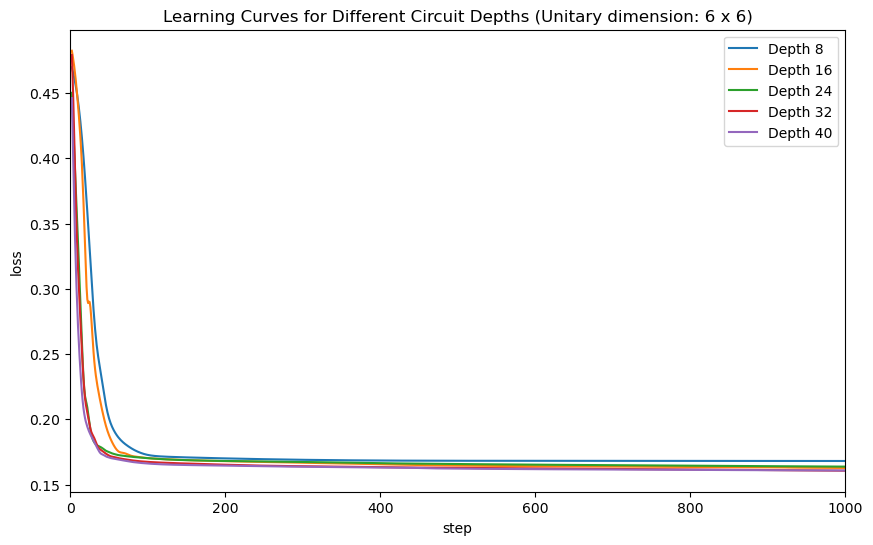

 depth  train_loss_before  train_loss_after  test_loss_after  train_time_min  total_time_min
     8             0.4699            0.1681           0.1820          0.0581          2.0962
    16             0.4825            0.1628           0.1772          0.3833          3.8184
    24             0.4502            0.1638           0.1791          0.5814          3.6157
    32             0.4792            0.1607           0.1808          0.9502          5.4429
    40             0.4462            0.1608           0.1789          1.7341          7.2263


In [ ]:
#Varying the depth of the circuit

depth_list = [8, 16, 24, 32, 40]# 48, 56, 64]  # Example depths
num_steps = 1000
step_size = 1e-2
# Load MNIST data for handwritten digits '3' and '5'
# The dataset has 'x' rows, each representing an image
# Each row has 'y' columns: The first y-1 columns each correspond to a pixel feature, and the last column is the label
# A label of +1 represents the digit '3', and -1 represents the digit '5'

file_path = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_3d_train.csv"
data_train = pd.read_csv(file_path)
data_train = jnp.array(data_train)


#final column in the data is for labels 
num_features = data_train.shape[1] -1 

file_path_1 = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_3d_test.csv"
data_test = pd.read_csv(file_path_1)
data_test = jnp.array(data_test)

num_steps = 1000


# Spliiting the data into training and testing sets

train_set = data_train[:,:num_features]

# Rescale the training set to the range [-pi/2, pi/2]
train_set = rescale_data(train_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

# The training labels are +1 for 3 and -1 for 5. 
train_labels = data_train[:,num_features]

# Not needed for now:
#train_labels_one_hot = jnp.zeros(shape = train_set.shape)
#train_labels_one_hot = train_labels_one_hot.at[tuple([jnp.arange(num_train),train_labels])].set(1)
test_set = data_test[:,:num_features]
# Rescale the test set to the range [-pi/2, pi/2]
test_set = rescale_data(test_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

test_labels = data_test[:,num_features]

results = []
plt.figure(figsize=(10, 6))

for depth in depth_list:
    print(f"Training with depth = {depth}")
    a = time.time()
    init_phases = initialize_phases(depth, 2*num_features)
    weights_data = jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = [
        init_phases, train_set, train_labels, weights_data,
        0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data
    ]
    b = time.time()
    carry, loss_mem = jax.block_until_ready(train)(init)
    e = time.time()
    trained_phases = carry[0]
    trained_weights = carry[3]

    train_loss_before = float(loss(init_phases, train_set, train_labels, weights_data))
    train_loss_after = float(loss(trained_phases, train_set, train_labels, trained_weights))
    test_loss_after = float(loss(trained_phases, test_set, test_labels, trained_weights))
    train_time_min = (e-b)/60
    
    plt.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), label=f"Depth {depth}")
    
    d = time.time()
    total_time_min = (d-a)/60

    results.append({
        "depth": depth,
        "train_loss_before": train_loss_before,
        "train_loss_after": train_loss_after,
        "test_loss_after": test_loss_after,
        "train_time_min": train_time_min,
        "total_time_min": total_time_min
    })


plt.xlim(0, num_steps)
plt.xlabel("step")
plt.ylabel("loss")
plt.title(f"Learning Curves for Different Circuit Depths (Unitary dimension: {2*init_phases.shape[1]} x {2*init_phases.shape[1]})")

plt.legend()
plt.show()

# Create and print the results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))   

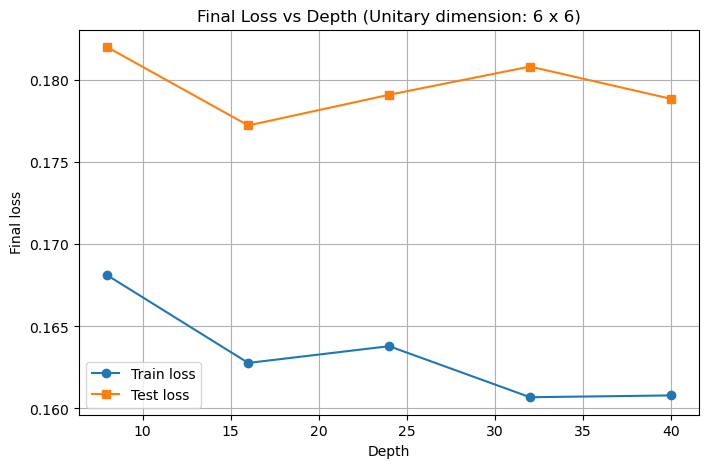

In [4]:
# Plot final losses vs depth 
depth = [r["depth"] for r in results]
train_loss = [r["train_loss_after"] for r in results]
test_loss = [r["test_loss_after"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(depth, train_loss, 'o-', label="Train loss")
plt.plot(depth, test_loss, 's-', label="Test loss")
plt.xlabel("Depth")
plt.ylabel("Final loss")
plt.title(f"Final Loss vs Depth (Unitary dimension: 6 x 6)")
plt.legend()
plt.grid(True)
plt.show()

Training with 3 features (depth=32)
Training with 4 features (depth=32)
Training with 5 features (depth=32)
Training with 6 features (depth=32)
Training with 7 features (depth=32)
Training with 8 features (depth=32)
Training with 9 features (depth=32)
Training with 10 features (depth=32)


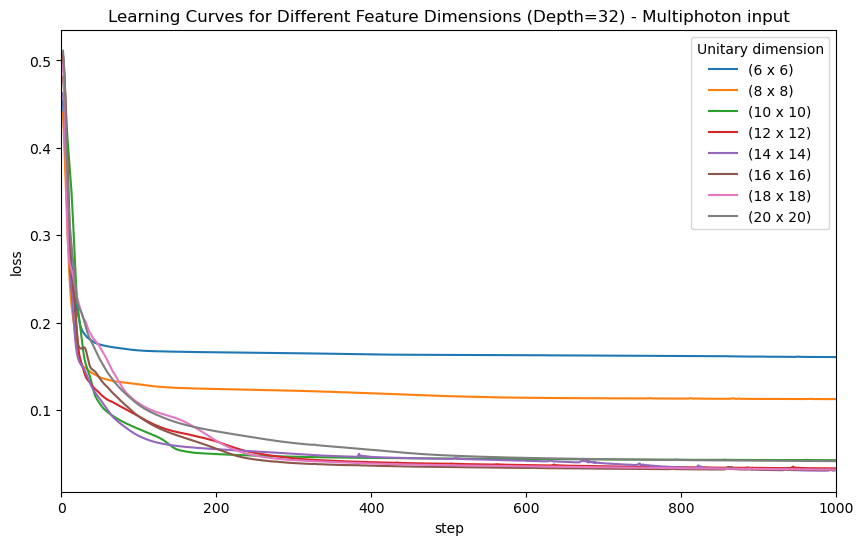

 features  train_loss_before  train_loss_after  test_loss_after  train_time_min  total_time_min
        3             0.4534            0.1608           0.1788          1.9617          8.8010
        4             0.4403            0.1127           0.1283          2.6844         10.4139
        5             0.5064            0.0429           0.0681          2.4522         15.0157
        6             0.5056            0.0335           0.0617          4.2629         25.7945
        7             0.4624            0.0308           0.0540          6.8705         40.2637
        8             0.4811            0.0318           0.0629          7.8105         52.6259
        9             0.4975            0.0321           0.1258         17.7111         82.5902
       10             0.5111            0.0417           0.1560         12.7937         96.5957


In [6]:
# Varying the number of features

feature_dims = list(range(3, 11))  # 3d to 10d
depth = 32                         # Set your desired constant depth here
num_steps = 1000
step_size = 1e-2

results = []
plt.figure(figsize=(10, 6))

for f_dims in feature_dims:
    print(f"Training with {f_dims} features (depth={depth})")
    a =time.time()
    file_path_train = fr"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_{f_dims}d_train.csv"
    file_path_test  = fr"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_{f_dims}d_test.csv"
    data_train = pd.read_csv(file_path_train)
    data_train = jnp.array(data_train)
    data_test = pd.read_csv(file_path_test)
    data_test = jnp.array(data_test)
    num_features = data_train.shape[1] - 1

    train_set = data_train[:, :num_features]
    train_set = rescale_data(train_set, min_val=-(np.pi)/2, max_val=(np.pi/2))
    train_labels = data_train[:, num_features]
    test_set = data_test[:, :num_features]
    test_set = rescale_data(test_set, min_val=-(np.pi)/2, max_val=(np.pi/2))
    test_labels = data_test[:, num_features]

    a = time.time()
    init_phases = initialize_phases(depth, 2*num_features)
    weights_data = jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = [
        init_phases, train_set, train_labels, weights_data,
        0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data
    ]
    b = time.time()
    carry, loss_mem = jax.block_until_ready(train)(init)
    e = time.time()
    trained_phases = carry[0]
    trained_weights = carry[3]

    train_loss_before = float(loss(init_phases, train_set, train_labels, weights_data))
    train_loss_after = float(loss(trained_phases, train_set, train_labels, trained_weights))
    test_loss_after = float(loss(trained_phases, test_set, test_labels, trained_weights))
    train_time_min = (e-b)/60

    plt.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), label=f"({2*f_dims} x {2*f_dims})")


    d = time.time()
    total_time_min = (d-a)/60
    results.append({
        "features": f_dims,
        "train_loss_before": train_loss_before,
        "train_loss_after": train_loss_after,
        "test_loss_after": test_loss_after,
        "train_time_min": train_time_min,
        "total_time_min": total_time_min
    })

plt.xlim(0, num_steps)
plt.xlabel("step")
plt.ylabel("loss")
plt.title(f"Learning Curves for Different Feature Dimensions (Depth={depth}) - Multiphoton input")

plt.legend(title="Unitary dimension")
plt.show()

# Create and print the results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))

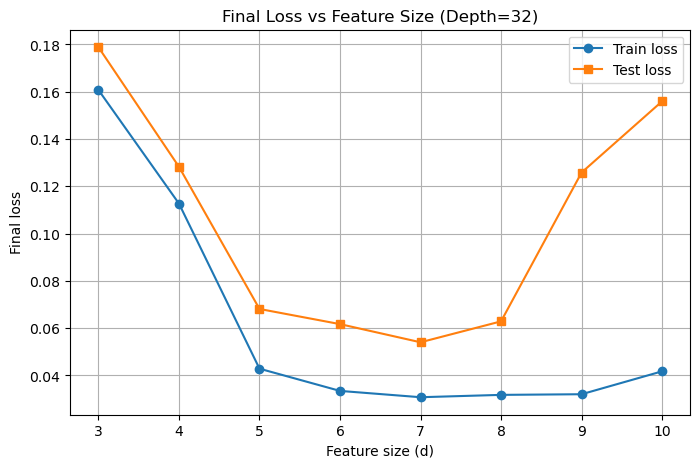

In [7]:
# Plot final losses vs feature size
features = [r["features"] for r in results]
train_loss = [r["train_loss_after"] for r in results]
test_loss = [r["test_loss_after"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(features, train_loss, 'o-', label="Train loss")
plt.plot(features, test_loss, 's-', label="Test loss")
plt.xlabel("Feature size (d)")
plt.ylabel("Final loss")
plt.title(f"Final Loss vs Feature Size (Depth={depth})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#check multiphoton output combinations

# Example usage of the measurement function
n = 3  # number of matrices
size = 6  # size of each identity matrix

# Create a (n, 1, 1) array of factors: [0], [1], [2]
factors = jnp.arange(n, dtype=jnp.complex64).reshape(-1, 1, 1)
# Create a (1, 6, 6) identity matrix and broadcast
ones_matrix = jnp.arange(n * size * size, dtype=jnp.complex64).reshape(n, size, size)
# Multiply to get (n, 6, 6)
temp_unitaries = factors * ones_matrix

#print(temp_unitaries.shape)  # (3, 6, 6)
#print(temp_unitaries)

result_measurement, combos1, probs1, _ = measurement(temp_unitaries, num_photons = 3)
#print(probs1)
#print(result_measurement.shape)  # Should be (num_samples, 2, 6) if num_samples is the batch size
parity = jnp.sum(combos1, axis=1) % 2
mask = (parity == 1)  # shape (n_combos,)

arr = jnp.arange(1, 21)
test = parity*arr
test1 = mask*arr
print("Masked array:", test1)
print("Even indices:", test)
print(parity)  # 0 = even, 1 = odd
print(combos1)



Masked array: [ 1  0  3  0  5  0  7  8  0 10  0 12  0  0 15  0 17  0 19  0]
Even indices: [ 1  0  3  0  5  0  7  8  0 10  0 12  0  0 15  0 17  0 19  0]
[1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0]
[[0 1 2]
 [0 1 3]
 [0 1 4]
 [0 1 5]
 [0 2 3]
 [0 2 4]
 [0 2 5]
 [0 3 4]
 [0 3 5]
 [0 4 5]
 [1 2 3]
 [1 2 4]
 [1 2 5]
 [1 3 4]
 [1 3 5]
 [1 4 5]
 [2 3 4]
 [2 3 5]
 [2 4 5]
 [3 4 5]]


In [9]:
#check permanent calculation

def perm_3x3_jax(mat):
    # Only works for 3x3 matrices
    perms = jnp.array([
        [0, 1, 2],
        [0, 2, 1],
        [1, 0, 2],
        [1, 2, 0],
        [2, 0, 1],
        [2, 1, 0]
    ])
    return jnp.sum(jnp.prod(mat[jnp.arange(3), perms], axis=1))

# Example usage
mat = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=jnp.complex64)
result_perm = perm_3x3_jax(mat) 
print("Permanent of the matrix:", result_perm)  # Should print the permanent of the matrix
mat1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=jnp.complex64)
print("Permanent of the matrix (using numpy):", perm(mat1))  # For comparison with numpy's perm function

Permanent of the matrix: (450+0j)
Permanent of the matrix (using numpy): (450+0j)
